In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
import pylab as pl
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
import requests
from requests_futures.sessions import FuturesSession
from bs4 import BeautifulSoup
import re
import urllib 
import os
import sys
import pandas as pd
sys.path.append('/usr/local/lib/python2.7/dist-packages') 
import vincent

In [2]:
os.chdir('/home/seth/workspace_Unix/dataIncub/bbp/')

In [3]:
industry_codes_2digit=pd.read_table('/home/seth/workspace_Unix/dataIncub/bbp/refs/NAICS_2digit.txt',index_col=False, sep=';')
industry_codes_2digit['NAICS_2digit']=industry_codes_2digit['NAICS_2digit'].astype(str)
industry_codes_2digit

,NAICS_2digit,Industry_Group
0,11,"Agriculture, Forestry, Fishing and Hunting"
1,21,"Mining, Quarrying, and Oil and Gas Extraction"
2,22,Utilities
3,23,Construction
4,31,Manufacturing
5,32,Manufacturing
6,33,Manufacturing
7,42,Wholesale Trade
8,44,Retail Trade
9,45,Retail Trade


In [4]:
industry_codes=pd.read_excel('/home/seth/workspace_Unix/dataIncub/bbp/refs/6-digit_2012_Codes.xls',sheetname='2012_6-digit_industries',index_col=False, sep=';')
print industry_codes.shape
industry_codes.columns=['NAICS2012','Industry_Desc']
industry_codes=industry_codes.drop(industry_codes.index[0]) #remove empty row
industry_codes['NAICS2012']=industry_codes['NAICS2012'].astype(int).astype(str)
industry_codes.head()

(1066, 2)


,NAICS2012,Industry_Desc
1,111110,Soybean Farming
2,111120,Oilseed (except Soybean) Farming
3,111130,Dry Pea and Bean Farming
4,111140,Wheat Farming
5,111150,Corn Farming


In [5]:
##Get County FIPS IDs
county_fips_url='http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt'
county_fips=pd.read_table(county_fips_url, sep=',', header=None, names=['state_abbrev','state_fp', 'county_fp', 'countyName', 'fp_class_code'])
county_fips['state_county_code']=county_fips['state_fp']*1000+county_fips['county_fp']
county_fips['st_county_id_str']=county_fips['state_county_code'].map("{:05}".format)
county_fips.head()

,state_abbrev,state_fp,county_fp,countyName,fp_class_code,state_county_code,st_county_id_str
0,AL,1,1,Autauga County,H1,1001,01001
1,AL,1,3,Baldwin County,H1,1003,01003
2,AL,1,5,Barbour County,H1,1005,01005
3,AL,1,7,Bibb County,H1,1007,01007
4,AL,1,9,Blount County,H1,1009,01009


In [6]:
#econ example call: http://api.census.gov/data/2012/ewks?get=ST,COUNTY,EMP,RCPTOT,PAYANN,ESTAB,NAICS2012,OPTAX&for=state:*&NAICS2012=54&key=77912556e5965544a3093efa3cb2305807fbe56c
url='http://api.census.gov/data/2012/ewks?get=ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX&for=county:*&&NAICS2012=31-33&key=77912556e5965544a3093efa3cb2305807fbe56c'
session = FuturesSession(max_workers=15)

# multiple resolutions available:state, county, censusplace, msa, usf, statesenate, statehouse, congdistrict, tribalnation.
# print counties_stringsDF.head(1)
# urls=(base_url+counties_stringsDF+'?format=json').tolist()

#Send multiple requests at once
futures = session.get(url) 
state_response = futures.result()

In [7]:
print state_response.url
print state_response.text[-500:]

http://api.census.gov/data/2012/ewks?get=ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX&for=county:*&&NAICS2012=31-33&key=77912556e5965544a3093efa3cb2305807fbe56c
,"31-33","72","145"],
["72","147","31-33","0","0","0","2","99","31-33","72","147"],
["72","149","31-33","0","0","0","3","99","31-33","72","149"],
["72","151","31-33","252","18462","3835","8","99","31-33","72","151"],
["72","153","31-33","543","69765","12873","15","99","31-33","72","153"],
["78","10","31-33","1718","1902390","156707","33","99","31-33","78","10"],
["78","20","31-33","0","1273","226","4","99","31-33","78","20"],
["78","30","31-33","248","58976","10974","20","99","31-33","78","30"]]


In [8]:
column_names=re.split(',', 'CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX')
base_url='http://api.census.gov/data/2012/ewks?get=CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX&for=county:*&&NAICS2012='
and_key='&key=77912556e5965544a3093efa3cb2305807fbe56c'
session = FuturesSession(max_workers=15)
urls=[]
for industry in industry_codes['NAICS2012']:
    urls.append(base_url+industry.strip()+and_key)
#     print base_url+industry+and_key
    
#Send multiple requests at once
futures = [session.get(url) for url in urls]
industry_responses = [future.result() for future in futures]

In [9]:
import pickle

In [10]:
output = open('industry_responses.pkl', 'wb')
pickle.dump(industry_responses, output)
output.close()

In [11]:
from StringIO import StringIO as strIO 

In [54]:
industryDFs=[]
for industry_response in industry_responses:
    try:
        braces_removed=re.sub('\[|]','',industry_response.text)
        industryDFs.append(pd.read_csv(strIO(braces_removed), sep=","))
    except:
        1 #print 'no data for an industry'

industryDF=pd.concat(industryDFs)

In [56]:
industryDF.shape

(360867, 13)

In [57]:
industryDF['NAICS2012']=industryDF['NAICS2012'].astype(str)

In [58]:
def pullfirst2chars(aString):
    return aString[0:2]

In [59]:
industryDF['NAICS_2digit']=industryDF['NAICS2012'].apply(pullfirst2chars)
industryDF['NAICS_2digit'].head()

0    22
1    22
2    22
3    22
4    22
Name: NAICS_2digit, dtype: object

In [60]:
industryDF=pd.merge(industryDF, industry_codes, on='NAICS2012' )
industryDF.shape

(360867, 15)

In [61]:
industryDF=pd.merge(industryDF,industry_codes_2digit, on='NAICS_2digit')
industryDF.tail()

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,state,county,Unnamed: 12,NAICS_2digit,Industry_Desc,Industry_Group
360862,999,56,37,812990,0,0,0,1,T,812990,56,37,NaN,81,All Other Personal Services,Other Services (except Public Administration)
360863,999,56,39,812990,0,0,0,4,A,812990,56,39,NaN,81,All Other Personal Services,Other Services (except Public Administration)
360864,999,56,39,812990,0,0,0,4,T,812990,56,39,NaN,81,All Other Personal Services,Other Services (except Public Administration)
360865,999,56,41,812990,0,0,0,1,A,812990,56,41,NaN,81,All Other Personal Services,Other Services (except Public Administration)
360866,999,56,41,812990,0,0,0,1,T,812990,56,41,NaN,81,All Other Personal Services,Other Services (except Public Administration)


In [62]:
industryDF.NAICS_2digit.value_counts()

42    50336
44    41338
54    39540
62    34368
81    28322
72    18392
45    18260
53    18111
56    17649
71    17509
48    16475
33    13113
52    12413
51     9300
61     8171
32     7110
22     4146
31     3364
49     2950
dtype: int64

In [63]:
industryDF.shape

(360867, 16)

In [64]:
industryDF['state_county_code']= industryDF['ST']*1000+industryDF['COUNTY']
industryDF=pd.merge(industryDF, county_fips, on='state_county_code' )
by_ST=industryDF[['state_abbrev', 'EMP']].groupby('state_abbrev')

In [65]:
industryDF.head()

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,...,NAICS_2digit,Industry_Desc,Industry_Group,state_county_code,state_abbrev,state_fp,county_fp,countyName,fp_class_code,st_county_id_str
0,999,1,15,221111,0,0,0,1,99,221111,...,22,Hydroelectric Power Generation,Utilities,1015,AL,1,15,Calhoun County,H1,01015
1,999,1,15,221115,0,0,0,1,99,221115,...,22,Wind Electric Power Generation,Utilities,1015,AL,1,15,Calhoun County,H1,01015
2,999,1,15,221122,0,0,0,9,99,221122,...,22,Electric Power Distribution,Utilities,1015,AL,1,15,Calhoun County,H1,01015
3,999,1,15,221210,0,0,0,1,99,221210,...,22,Natural Gas Distribution,Utilities,1015,AL,1,15,Calhoun County,H1,01015
4,999,1,15,221310,0,0,0,1,99,221310,...,22,Water Supply and Irrigation Systems,Utilities,1015,AL,1,15,Calhoun County,H1,01015


,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,...,Industry_Desc,Industry_Group,state_county_code,state_abbrev,state_fp,county_fp,countyName,fp_class_code,st_county_id_str,ST_tot_emp
0,999,1,15,221111,0,0,0,1,99,221111,...,Hydroelectric Power Generation,Utilities,1015,AL,1,15,Calhoun County,H1,01015,305349
1,999,1,15,221115,0,0,0,1,99,221115,...,Wind Electric Power Generation,Utilities,1015,AL,1,15,Calhoun County,H1,01015,305349
2,999,1,15,221122,0,0,0,9,99,221122,...,Electric Power Distribution,Utilities,1015,AL,1,15,Calhoun County,H1,01015,305349
3,999,1,15,221210,0,0,0,1,99,221210,...,Natural Gas Distribution,Utilities,1015,AL,1,15,Calhoun County,H1,01015,305349
4,999,1,15,221310,0,0,0,1,99,221310,...,Water Supply and Irrigation Systems,Utilities,1015,AL,1,15,Calhoun County,H1,01015,305349


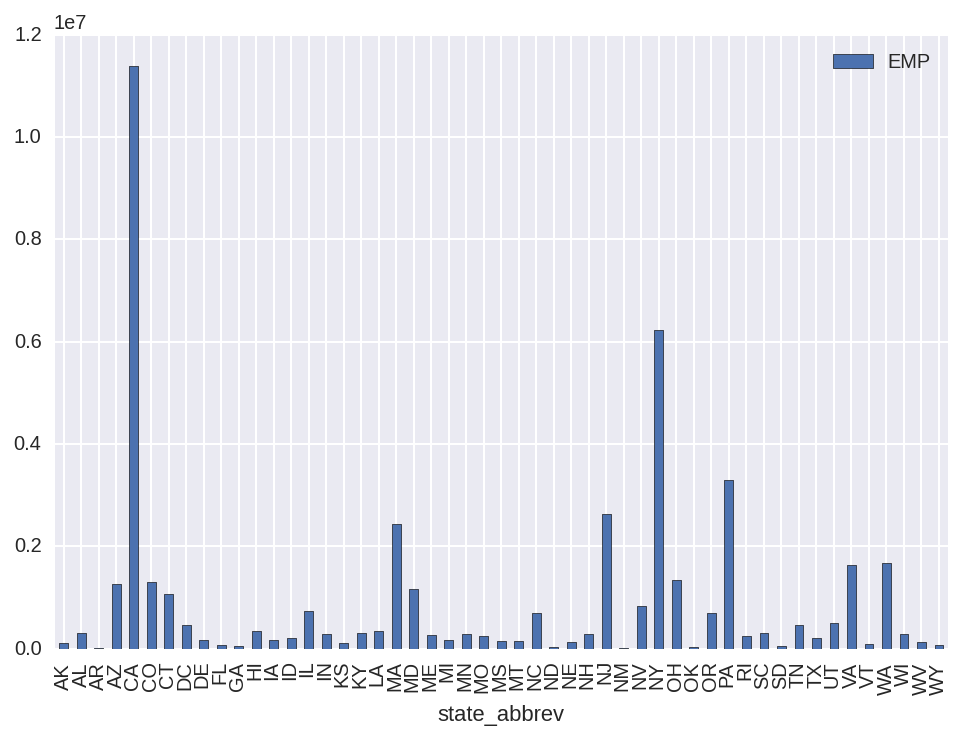

In [66]:
workforce_by_state=by_ST.sum()
p1=workforce_by_state.plot(kind='bar')
workforce_by_state=workforce_by_state.reset_index()
workforce_by_state.columns=['state_abbrev', 'ST_tot_emp']
workforce_by_state.head()
industryDF=pd.merge(industryDF, workforce_by_state, on='state_abbrev' )
industryDF.head()

In [67]:
emp_by_industry=industryDF[['Industry_Group', 'EMP']].groupby('Industry_Group')

,Industry_Group,Industry_tot_emp
0,Accommodation and Food Services,7896691
1,Administrative and Support and Waste Manag...,2873452
2,"Arts, Entertainment, and Recreation",1037027
3,Educational Services,403788
4,Finance and Insurance,2035837


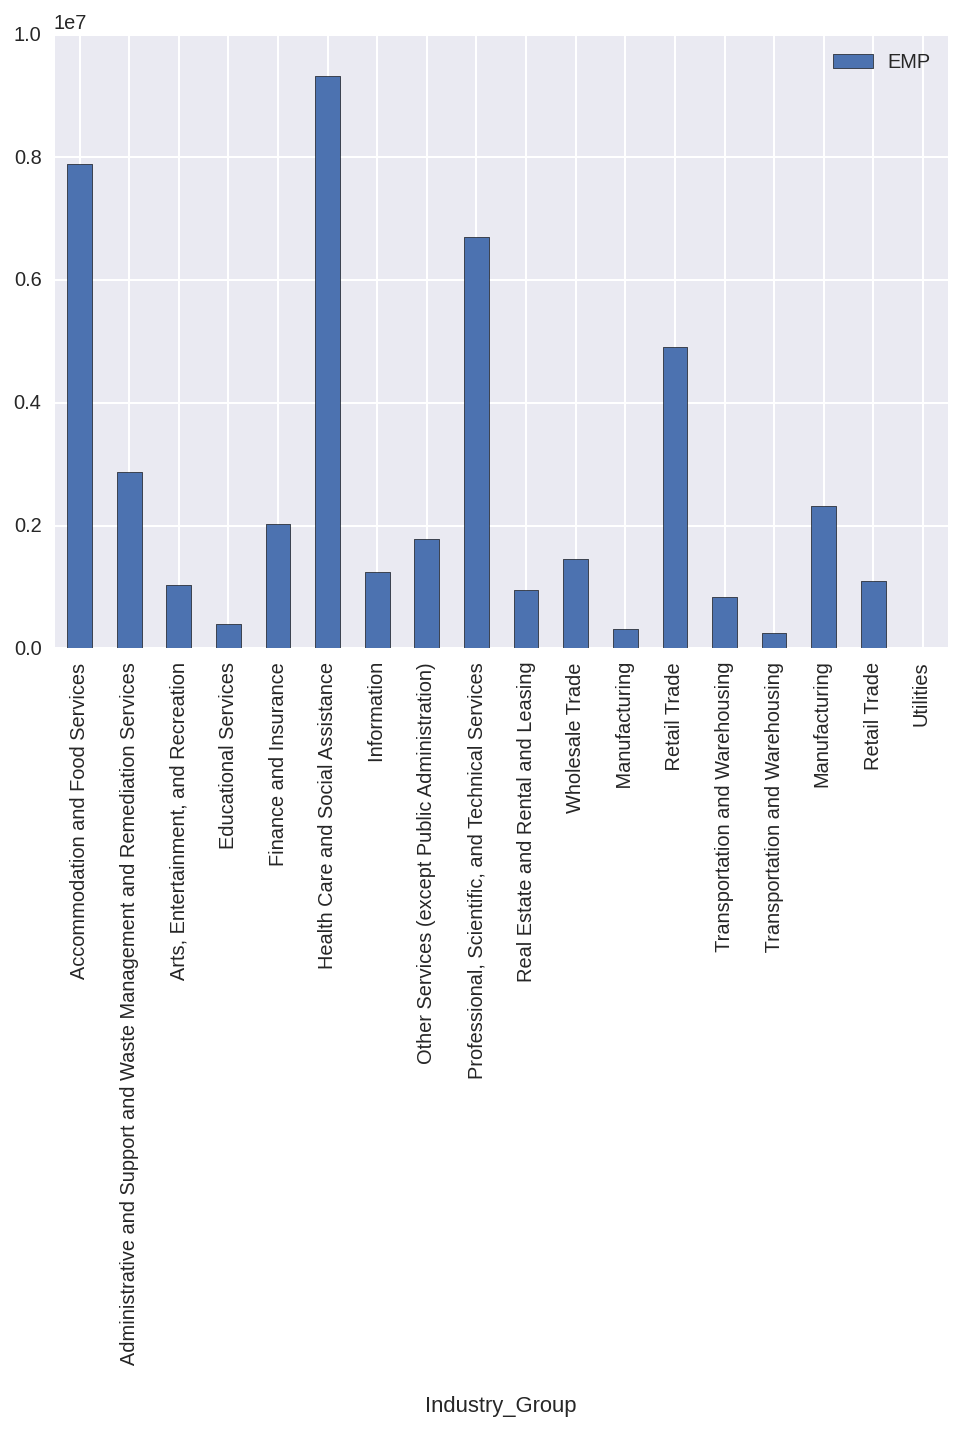

In [68]:
workforce_by_industry=emp_by_industry.sum()
workforce_by_industry.plot(kind='bar')
workforce_by_industry=workforce_by_industry.reset_index()
workforce_by_industry.columns=['Industry_Group', 'Industry_tot_emp']
workforce_by_industry.head()

In [69]:
industryDF.tail()

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,...,Industry_Desc,Industry_Group,state_county_code,state_abbrev,state_fp,county_fp,countyName,fp_class_code,st_county_id_str,ST_tot_emp
360862,999,35,3,423940,0,0,0,1,10,423940,...,"Jewelry, Watch, Precious Stone, and Precious M...",Wholesale Trade,35003,NM,35,3,Catron County,H1,35003,8014
360863,999,35,53,424490,0,0,0,1,10,424490,...,Other Grocery and Related Products Merchant Wh...,Wholesale Trade,35053,NM,35,53,Socorro County,H1,35053,8014
360864,999,35,19,424520,0,0,0,1,10,424520,...,Livestock Merchant Wholesalers,Wholesale Trade,35019,NM,35,19,Guadalupe County,H1,35019,8014
360865,999,35,23,424710,0,0,0,1,10,424710,...,Petroleum Bulk Stations and Terminals,Wholesale Trade,35023,NM,35,23,Hidalgo County,H1,35023,8014
360866,999,35,23,424920,0,0,0,1,10,424920,...,"Book, Periodical, and Newspaper Merchant Whole...",Wholesale Trade,35023,NM,35,23,Hidalgo County,H1,35023,8014


In [70]:
industryDF=pd.merge(industryDF, workforce_by_industry, on='Industry_Group' )

In [71]:

# workforce_by_state.columns=['index', 'state_abbrev', 'ST_tot_emp']
workforce_by_state.head()

,state_abbrev,ST_tot_emp
0,AK,112359
1,AL,305349
2,AR,19109
3,AZ,1271948
4,CA,11393870


In [72]:
industryDF.columns

Index([u'CSA', u'ST', u'COUNTY', u'NAICS2012', u'EMP', u'RCPTOT', u'PAYANN',
       u'ESTAB', u'OPTAX', u'NAICS2012.1', u'state', u'county', u'Unnamed: 12',
       u'NAICS_2digit', u'Industry_Desc', u'Industry_Group',
       u'state_county_code', u'state_abbrev', u'state_fp', u'county_fp',
       u'countyName', u'fp_class_code', u'st_county_id_str', u'ST_tot_emp',
       u'Industry_tot_emp'],
      dtype='object')

In [73]:
by_both=industryDF[['ST','Industry_Group', 'EMP']].groupby(['ST','Industry_Group'])

In [74]:
output = open('industryDF.pkl', 'wb')
pickle.dump(industryDF, output)
output.close()

In [75]:
emp_by_county=industryDF[['state_county_code', 'EMP']].groupby('state_county_code')

In [76]:
workforce_by_county=emp_by_county.sum()

In [77]:
workforce_by_county=emp_by_county.sum()
# workforce_by_county.plot(kind='bar')
workforce_by_county=workforce_by_county.reset_index()
workforce_by_county.columns=['state_county_code', 'county_tot_emp']

In [78]:
workforce_by_county.head()

,state_county_code,county_tot_emp
0,1001,1241
1,1003,19168
2,1005,1087
3,1007,191
4,1009,613
